In [5]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor


import cv2 as cv
import os
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
def showImage(img):
    plt.imshow("title", img)

In [14]:
class FeatureBag:
    def __init__(self, seed=42):
        self.seed = seed
        self.features = []
        transform = ToTensor()
        train_set = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
        test_set = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
        for image, _ in tqdm(train_set + test_set, "Extracting features from CIFAR10"):
            image_np = np.transpose(image.numpy(), (1, 2, 0))
            image_np = (image_np * 255).astype(np.uint8)
            gray = cv.cvtColor(image_np, cv.COLOR_BGR2GRAY)
            sift = cv.SIFT_create()
            keypoints, descriptors = sift.detectAndCompute(gray, None)
            if descriptors is not None : 
                self.features.extend(descriptors)
        print(f"Total number of features: {len(self.features)}")
        
    def cluster(self, k, verbose=True):
        self.k = k
        self.kmeans = KMeans(
            n_clusters = self.k,
            random_state = self.seed,
        ).fit(self.features)
        if verbose:
            print(f"Clustering with {self.k} clusters complete")

    def elbowCurve(self, ks):
        ks = sorted(ks)
        inertias = []
        for k in tqdm(ks, "Clustering with different values of k"):
            self.cluster(k, verbose=False)
            inertias.append(self.kmeans.inertia_)
        plt.plot(ks, inertias, marker='x')
        plt.title('Elbow Method for Optimal Clusters')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.show()
        
    def assignLabel(self, image):
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        sift = cv.SIFT_create()
        k, descriptors  = sift.detectAndCompute(gray, None)
        histogram = [0]*self.k
        if descriptors is not None : 
            for descriptor in descriptors:
                label = self.kmeans.predict(descriptor.reshape(1, -1).astype('double'))
                histogram[label[0]] += 1
        return histogram

In [15]:
featurebag = FeatureBag()

Files already downloaded and verified
Files already downloaded and verified


Extracting features from CIFAR10:   0%|          | 0/60000 [00:00<?, ?it/s]

Total number of features: 780742


Clustering with different values of k:   0%|          | 0/20 [00:00<?, ?it/s]

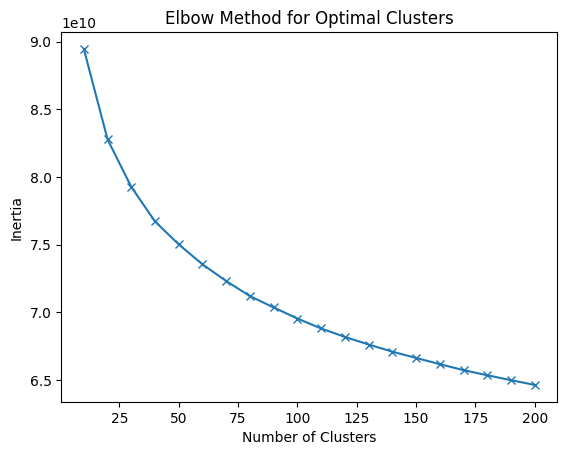

In [9]:
featurebag.elbowCurve(range(10, 201, 10))

In [16]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split

class Dataset:
    def __init__(self, classes, featureBag, seed=42):
        self.classes = classes
        self.featureBag = featureBag
        self.seed = seed
        self.load_dataset()
        self.createHistograms()
        self.trainTestSplit()

    def load_dataset(self):
        self.images = []
        self.labels = []
        transform = ToTensor()
        train_set = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
        for image, label in tqdm(train_set):
            image_np = np.transpose(image.numpy(), (1, 2, 0))
            image_np = (image_np * 255).astype(np.uint8)
            self.images.append(image_np)
            self.labels.append(label)

    def createHistograms(self):
        self.histograms = []
        for label_idx, label in enumerate(self.classes):
            class_histograms = []
            for idx, img in enumerate(self.images):
                if self.labels[idx] == label_idx:
                    histogram = self.featureBag.assignLabel(img)
                    class_histograms.append(histogram)
            self.histograms.append(np.array(class_histograms))

    def trainTestSplit(self):
        X = np.concatenate(self.histograms)
        y = []
        for label_idx, label in enumerate(self.classes):
            y.extend([label_idx]*self.histograms[label_idx].shape[0])
        self.X_train, self.X_test, self.y_train, self.y_test =  train_test_split(X, y, test_size=0.2, stratify=y, random_state=self.seed)


In [18]:
featurebag.cluster(80, verbose = True)

Clustering with 80 clusters complete


In [21]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset = Dataset(classes, featurebag)

Files already downloaded and verified


  0%|          | 0/50000 [00:00<?, ?it/s]

In [22]:
dataset.X_train.shape, dataset.X_test.shape

((40000, 80), (10000, 80))

### Training models

Now that we have data in our desired format, we can train various models and compare their performances.

#### SVM

In [23]:
svm_clf = svm.SVC()
svm_clf.fit(dataset.X_train, dataset.y_train)

svm_preds = svm_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, svm_preds))

#### Logistic Regression

In [ ]:
lg_clf = LogisticRegression()
lg_clf.fit(dataset.X_train, dataset.y_train)

lg_preds = lg_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, lg_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.90      0.95      0.93        20

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



c:\programming\projects\pj_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### KNN

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(dataset.X_train, dataset.y_train)

knn_preds = knn_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.90      0.90      0.90        20

    accuracy                           0.89        36
   macro avg       0.89      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



#### Gaussian Naive Bayes

In [ ]:
gnb_clf = GaussianNB()
gnb_clf.fit(dataset.X_train, dataset.y_train)

gnb_preds = gnb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, gnb_preds))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        16
           1       1.00      0.40      0.57        20

    accuracy                           0.67        36
   macro avg       0.79      0.70      0.65        36
weighted avg       0.81      0.67      0.64        36



#### Random Forest

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(dataset.X_train, dataset.y_train)

rf_preds = rf_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.85      0.92        20

    accuracy                           0.92        36
   macro avg       0.92      0.93      0.92        36
weighted avg       0.93      0.92      0.92        36



#### Gradient Boosting

In [ ]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(dataset.X_train, dataset.y_train)

gb_preds = gb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, gb_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.95      0.97        20

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



#### XGBoost

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(dataset.X_train, dataset.y_train)

xgb_preds = xgb_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.95      0.95      0.95        20

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36



#### LightGBM

In [ ]:
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(dataset.X_train, dataset.y_train)

lgbm_preds = lgbm_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, lgbm_preds))

[LightGBM] [Info] Number of positive: 79, number of negative: 64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 143, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552448 -> initscore=0.210565
[LightGBM] [Info] Start training from score 0.210565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

#### CatBoost

In [ ]:
cat_clf = CatBoostClassifier(verbose=False)
cat_clf.fit(dataset.X_train, dataset.y_train)

cat_preds = cat_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, cat_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.90      0.95        20

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



#### MLP Classifier

In [ ]:
mlp_clf = MLPClassifier()
mlp_clf.fit(dataset.X_train, dataset.y_train)

mlp_preds = mlp_clf.predict(dataset.X_test)

print(classification_report(dataset.y_test, mlp_preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.90      0.95      0.93        20

    accuracy                           0.92        36
   macro avg       0.92      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36

